# HR Analytics: Job Change of Data Scientists
### Feature

* enrollee_id : Unique ID for candidate

* city: City code

* city_ development _index : Developement index of the city (scaled)

* gender: Gender of candidate

* relevent_experience: Relevant experience of candidate

* enrolled_university: Type of University course enrolled if any

* education_level: Education level of candidate

* major_discipline :Education major discipline of candidate

* experience: Candidate total experience in years

* company_size: No of employees in current employer's company

* company_type : Type of current employer

* lastnewjob: Difference in years between previous job and current job

* training_hours: training hours completed

* target: 0 – Not looking for job change, 1 – Looking for a job change

## Data import & install

In [ ]:
!pip install -U pandas-profiling
!pip install category_encoders
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

!pip install catboost
!pip install shap
!pip install pdpbox
!pip install eli5

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import randint, uniform
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder
from category_encoders import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool, cv

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Binarizer
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import seaborn as sns
# import plotly.express as px
import matplotlib.pyplot as plt
import shap
from pdpbox.pdp import pdp_isolate, pdp_plot
import eli5
from eli5.sklearn import PermutationImportance

import matplotlib as mpl


mpl.rc("font", family='AppleGothic')
plt.rc('font', family='NanumBarunGothic')

%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


 ## Data 확인


In [ ]:
# Colab
# Data read
train = pd.read_csv('/content/drive/MyDrive/Project/Section2/Job Change/aug_train.csv')

In [ ]:
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [ ]:
rp = ProfileReport(train, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

 * `city` 컬럼은 매우 많은 범주를 가지고 있으며, 대부분의 컬럼은 missing value를 가지고 있다.

## Data analysis & Visualization

In [ ]:
# 필요없는 column drop & target column 분리
target = train['target']
train = train.iloc[:, :-1]
train = train.drop(['enrollee_id', 'city'], axis=1)

In [ ]:
# train, test set 분리
# stratify : target의 불균형에 따라 맞춰 분리
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, stratify =target, random_state=20)

In [ ]:
X_train.dtypes

city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
dtype: object

In [ ]:
# target값의 비율 확인
y_train.value_counts(normalize=True)

0.0    0.75062
1.0    0.24938
Name: target, dtype: float64

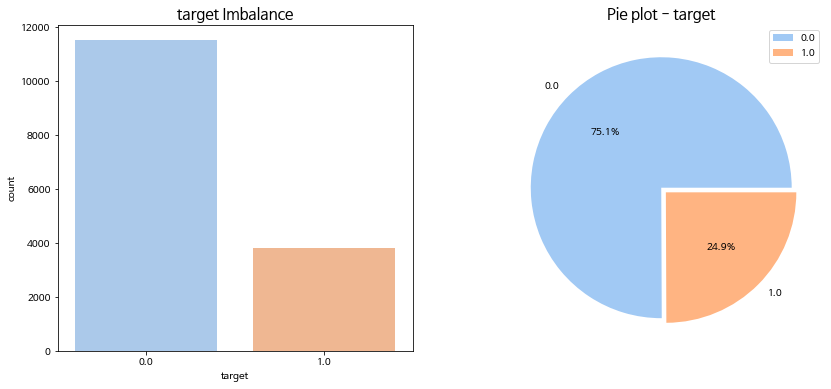

In [ ]:
# target plot
sns.set_palette('pastel')
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.countplot(y_train, ax=ax[0])
ax[0].set_title('target Imbalance', size=15)
y_train.value_counts().plot.pie(explode=[0, 0.05], autopct='%1.1f%%', ax=ax[1])
ax[1].set_title('Pie plot - target', size=15)
ax[1].set_ylabel('')
ax[1].legend()
plt.show()

In [ ]:
def engineer(df):
  # 인덱스 초기화
  df.reset_index(drop=True, inplace=True)
  # experience 클러스터링
  df['experience'].replace(['<1', '1', '2', '3', '4', '5'], '0-5', inplace=True)
  df['experience'].replace(['6', '7', '8', '9', '10'], '06-10', inplace=True)
  df['experience'].replace(['11', '12', '13', '14', '15'], '11-15', inplace=True)
  df['experience'].replace(['16', '17', '18', '19', '20'], '16-20', inplace=True)
  df['experience'].replace('>20', '20+', inplace=True)
  # company_size unique 재조정
  df['company_size'].replace({'10/49' : '10-49', '<10' : '0-10'}, inplace=True)
  # last_new_job unique 재조정
  df['last_new_job'].replace('>4', '4+', inplace=True)

engineer(X_train)
engineer(X_test)

In [ ]:
# target값의 인덱스 초기화
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [ ]:
# 데이터 분석용 df copy
df = X_train.copy()
df['target'] = y_train
df

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,06-10,NaN,NaN,1,46,1.0
1,0.920,Male,Has relevent experience,no_enrollment,Graduate,Other,20+,1000-4999,Pvt Ltd,4+,24,0.0
2,0.743,Male,Has relevent experience,no_enrollment,Graduate,Arts,11-15,NaN,NaN,1,80,1.0
3,0.649,Male,No relevent experience,no_enrollment,Graduate,STEM,11-15,100-500,Pvt Ltd,2,10,1.0
4,0.624,NaN,No relevent experience,Full time course,Masters,STEM,0-5,NaN,NaN,1,15,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
15321,0.910,Female,Has relevent experience,no_enrollment,Masters,STEM,0-5,10-49,Funded Startup,2,65,0.0
15322,0.913,Male,No relevent experience,no_enrollment,Phd,STEM,20+,1000-4999,Public Sector,4,78,0.0
15323,0.624,Male,No relevent experience,Full time course,High School,NaN,0-5,NaN,NaN,never,7,1.0
15324,0.579,NaN,No relevent experience,no_enrollment,Primary School,NaN,0-5,NaN,NaN,1,34,1.0


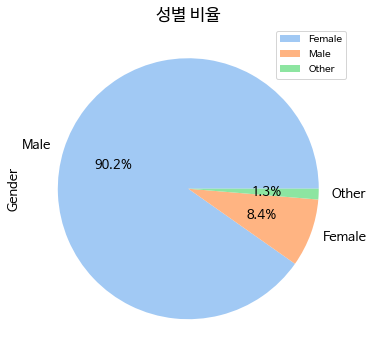

In [ ]:
# gender plot
plt.figure(figsize=(8, 6))
df['gender'].value_counts().plot.pie(autopct='%1.1f%%', fontsize=13)
plt.ylabel('Gender', size=13)
plt.legend(df['gender'].unique()[[0, 1, 3]])
plt.title('성별 비율', size=17)
plt.show()

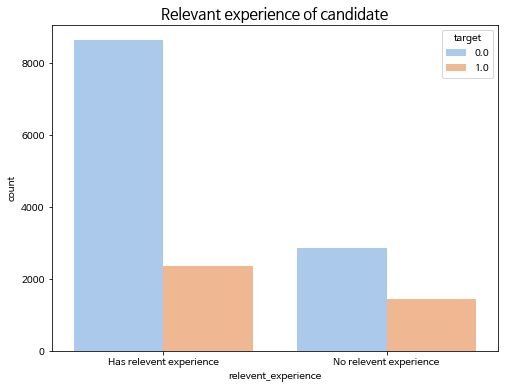

In [ ]:
# 관련 경혐 유무
# relevant experience plot
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='relevent_experience', hue='target')
plt.title('Relevant experience of candidate', size=15)
plt.show()

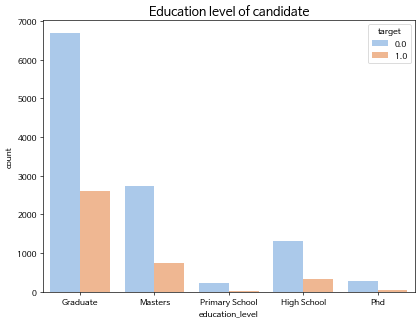

In [ ]:
# 교육 수준
# education level plot
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='education_level', hue='target')
plt.title('Education level of candidate', size=15)
plt.show()

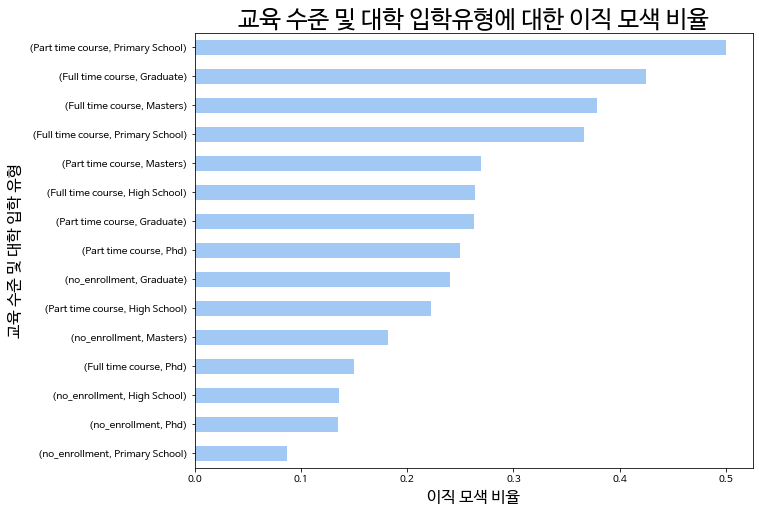

In [ ]:
plt.figure(figsize=(10, 8))
df.groupby(['enrolled_university', 'education_level'])['target'].mean().sort_values().plot.barh()
plt.xlabel('이직 모색 비율', size=16)
plt.ylabel('교육 수준 및 대학 입학 유형', size=16)
plt.title('교육 수준 및 대학 입학유형에 대한 이직 모색 비율', size=24)
plt.show()

* 대학 과정이 있는 경우가 다른 경우보다 상대적으로 높다.
* 가장 높은 비율을 차지하는 항목은 part time course, Primary School 항목으로 약 50%이다.
* 가장 적은 비율은 no_enrollment, Primary School 으로 약 9%이다.

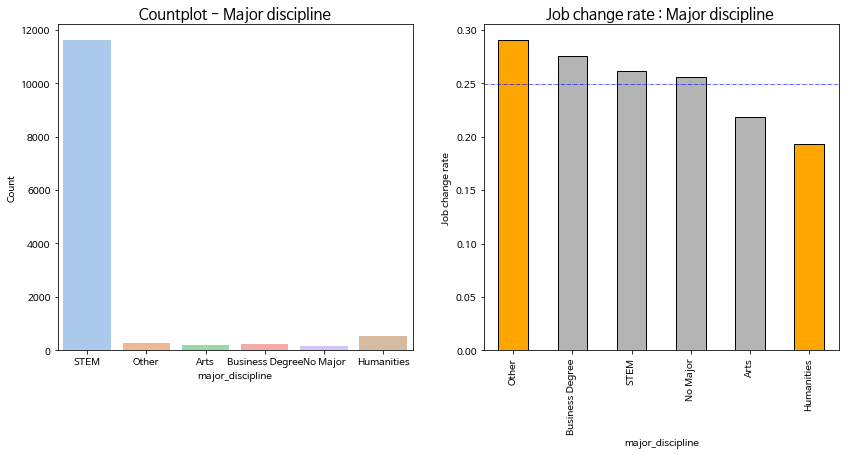

In [ ]:
# bar color
bar_color = ['#b4b4b4' for _ in range(6)]
bar_color[0] = bar_color[5] = '#FFA500'


# Major discipline count plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(df['major_discipline'], ax=ax[0])
ax[0].set_ylabel('Count',size=10)
ax[0].set_title('Countplot - Major discipline', size=15)
# Major discipline target rate plot
df.groupby('major_discipline')['target'].mean().sort_values(ascending=False).plot.bar(color= bar_color, edgecolor='black')

# target mean hline plot
mean = df['target'].mean()
ax[1].axhline(mean ,color='blue', linewidth=0.6, linestyle='dashdot')
ax[1].set_ylabel('Job change rate', size=10)
ax[1].set_title('Job change rate : Major discipline ', size=15)
plt.show()

 
* 교육전공은 **STEM**가 88%의 비중을 차지하고 있다.     
* 가장 높은 `Other`는 약 29% 정도 이직을 생각 하고 있고, 
가장 적은`Humanities`는 19% 정도 이직을 생각하고있다.


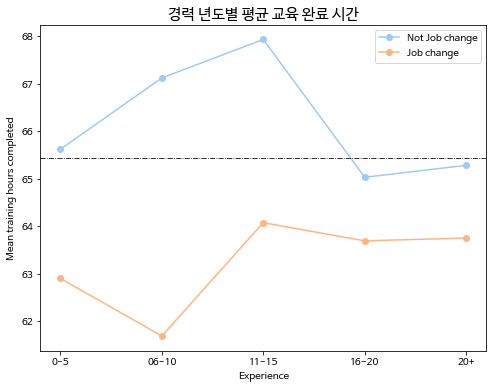

In [ ]:
target_0 = "target == 0"
target_1 = "target == 1"
# target값에 대한 groupby
exp_train_df = df.query(target_0).groupby('experience')['training_hours'].mean()
exp_train_df1 = df.query(target_1).groupby('experience')['training_hours'].mean()

df_exp = pd.concat((exp_train_df, exp_train_df1), axis=1)
df_exp.columns = ['Not Job change', 'Job change']
# 경력 년도별 교육 완료 시간 plot
plt.figure(figsize=(8, 6))
plt.plot(df_exp, 'o-')
mean = df['training_hours'].mean()
plt.axhline(mean ,color='black', linewidth=0.8, linestyle='dashdot')
plt.legend(df_exp.columns)
plt.xlabel('Experience')
plt.ylabel('Mean training hours completed')
plt.title('경력 년도별 평균 교육 완료 시간', size=15)
plt.show()

* 이직을 생각하지 않는 그룹들이 이직을 생각하는 그룹보다 평균 교육 완료 시간이 월등히 높다.
* 총 경력이 16년 이상인 사람들은 교육 완료 시간이 평균보다 낮게 나오는 경향을 보여준다.

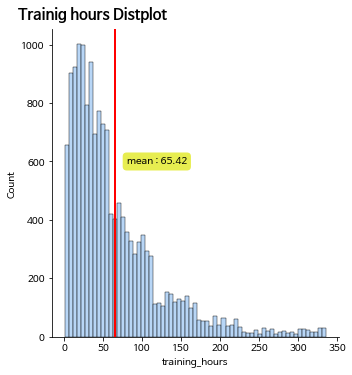

In [ ]:
# Training hour plot
sns.displot(df['training_hours'])
plt.axvline(df['training_hours'].mean(), color='red', linewidth=2)
plt.annotate(f"mean : {mean :.4}", 
            xy=(mean + 15, 600),
             va= 'center',
             ha='left',
            # color='#4a4a4a',
            bbox=dict(boxstyle='round', pad=0.4, facecolor='#E7ED50', linewidth=0))
plt.figtext(0.06, 1, 'Trainig hours Distplot', fontsize=15, fontweight='bold')
plt.show()

* 대부분의 교육시간은 0~50시간 정도 소요되고 있다. 
* 교육시간이 많은경우는 300시간이 넘어가는 경우도 보인다.

In [ ]:
# gender별 경력 df
gender_m = "gender == 'Male'"
gender_f = "gender == 'Female'"
gender_o = "gender == 'Other'"
df_m = df.query(gender_m).groupby('experience')['target'].mean()
df_f = df.query(gender_f).groupby('experience')['target'].mean()
df_o = df.query(gender_o).groupby('experience')['target'].mean()

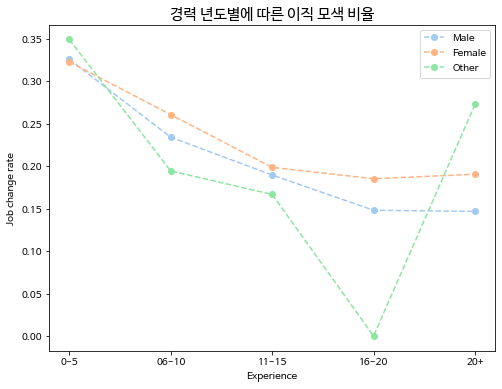

In [ ]:
df_gen = pd.concat((df_m, df_f, df_o), axis=1)
df_gen.columns = ['Male', 'Female', 'Other']

plt.figure(figsize=(8, 6))
plt.plot(df_gen, 'o--')
plt.legend(df_gen.columns)
plt.xlabel('Experience')
plt.ylabel('Job change rate')
plt.title('경력 년도별에 따른 이직 모색 비율', size=15)
plt.show()

* 경력이 낮을수록 이직 모색할 경향이 보였고, 경력이 올라갈수록 이직 비율이 점차 낮아지는 것을 확인 할 수 있다.

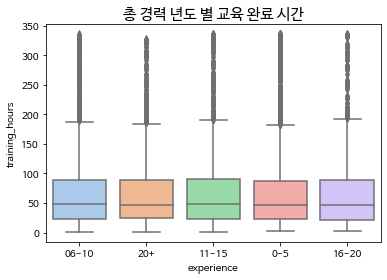

In [ ]:
sns.boxplot(x=df['experience'],y=df['training_hours'])
plt.title('총 경력 년도 별 교육 완료 시간', size=15)
plt.show()

In [ ]:
# 회사 규모와 target간의 df 생성
df_size = pd.crosstab(df['target'], df['company_size'])
df_size

company_size,0-10,10-49,100-500,1000-4999,10000+,50-99,500-999,5000-9999
target,,,,,,,,
0.0,863,906,1709,887,1329,2011,589,364
1.0,176,282,319,165,314,448,127,77


In [ ]:
# company size 순서 재조정
df_size = df_size.reindex(columns=['0-10', '10-49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999'])
df_size = df_size.T

In [ ]:
df_size

target,0.0,1.0
company_size,,
0-10,863,176
10-49,906,282
50-99,2011,448
100-500,1709,319
500-999,589,127
1000-4999,887,165
5000-9999,364,77


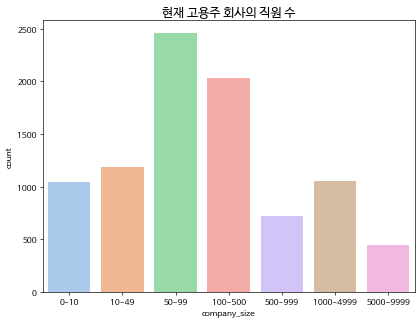

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=df_size.index, y=df_size.sum(axis=1))
plt.ylabel('count')
plt.title('현재 고용주 회사의 직원 수', size=15)
plt.show()

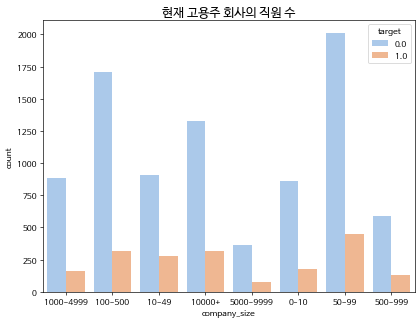

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(df['company_size'], hue=df['target'])
plt.ylabel('count')
plt.title('현재 고용주 회사의 직원 수', size=15)
plt.show()

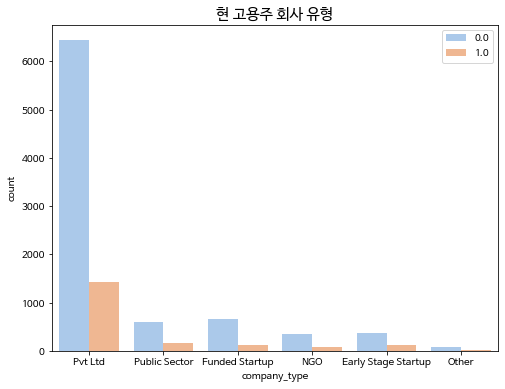

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x=df['company_type'], hue=df['target'])
plt.title('현 고용주 회사 유형', size=15)
plt.legend()
plt.show()

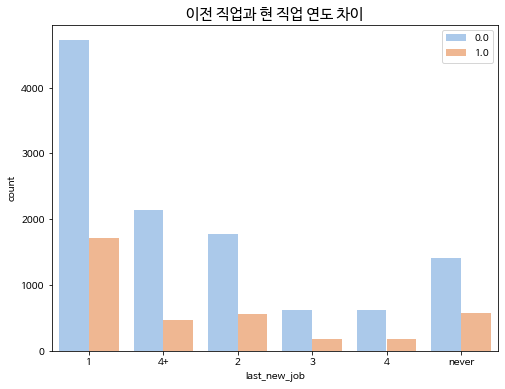

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x=df['last_new_job'], hue=df['target'])
plt.title('이전 직업과 현 직업 연도 차이', size=15)
plt.legend()
plt.show()

## Model

In [ ]:
# LGBM 모델
light_pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    LGBMClassifier(class_weight='balanced', n_jobs=-1, random_state=20)
)
light_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['gender', 'relevent_experience',
                                      'enrolled_university', 'education_level',
                                      'major_discipline', 'experience',
                                      'company_size', 'company_type',
                                      'last_new_job'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'gender',
                                          'data_type': dtype('O'),
                                          'mapping': Female    1
Ma...
                 LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child

In [ ]:
# LGBM 교차 검증 점수
light_pipe_cross = cross_val_score(light_pipe, X_train, y_train, cv=5, scoring='roc_auc',)

print('cross val score : ', light_pipe_cross.mean())

cross val score :  0.7973358267145056


In [ ]:
# XGB 모델 학습
xgb_pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(scale_pos_weight=3, n_jobs=-1, random_state=20)
)
xgb_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['gender', 'relevent_experience',
                                      'enrolled_university', 'education_level',
                                      'major_discipline', 'experience',
                                      'company_size', 'company_type',
                                      'last_new_job'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'gender',
                                          'data_type': dtype('O'),
                                          'mapping': Female    1
Ma...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0,

In [ ]:
# XGB 교차검증
xgb_pipe_cross = cross_val_score(xgb_pipe, X_train, y_train, cv=5, scoring='roc_auc',)

print('cross val score : ', xgb_pipe_cross.mean())

cross val score :  0.800158984157051


In [ ]:
# CatBoost 모델 학습
cat_pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    CatBoostClassifier(auto_class_weights='Balanced',random_state=20)
)
cat_pipe.fit(X_train, y_train)

In [ ]:
# CatBoost 교차검증
cat_pipe_cross = cross_val_score(cat_pipe, X_train, y_train, cv=5, scoring='roc_auc',)

print('cross val score : ', cat_pipe_cross.mean())

In [ ]:
# RandomForest 모델 학습
rf_pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(class_weight='balanced',n_jobs=-1 ,random_state=20)
)
rf_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['gender', 'relevent_experience',
                                      'enrolled_university', 'education_level',
                                      'major_discipline', 'experience',
                                      'company_size', 'company_type',
                                      'last_new_job'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'gender',
                                          'data_type': dtype('O'),
                                          'mapping': Female    1
Ma...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=None,
                                        max_features='

In [ ]:
# RandomForest 교차 검증
rf_pipe_cross = cross_val_score(rf_pipe, X_train, y_train, cv=5, scoring='roc_auc')

print('cross val score : ', rf_pipe_cross.mean())

cross val score :  0.7801582304492445


In [ ]:
print('LGBM 모델 교차검증 score :', light_pipe_cross.mean())
print('XGB 모델 교차검증 score :', xgb_pipe_cross.mean())
print('CatBoost 모델 교차검증 score :', cat_pipe_cross.mean())
print('RandomForest 모델 교차검증 score :', rf_pipe_cross.mean())

LGBM 모델 교차검증 score : 0.7973358267145056
XGB 모델 교차검증 score : 0.800158984157051
CatBoost 모델 교차검증 score : 0.7965277580452257
RandomForest 모델 교차검증 score : 0.7801582304492445


In [ ]:
# XGBoost model Randomized Search CV
xgb_pipe = pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(scale_pos_weight=3, subsample=0.8, n_jobs=-1, random_state=20)
)
xgb_pipe.fit(X_train, y_train)

dist = {
    'simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
    'xgbclassifier__n_estimators': randint(50, 250),
    'xgbclassifier__max_depth': [3, 4, 5, 6, 7, 8],
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.2, 0.3]
}

clf= RandomizedSearchCV(
    xgb_pipe,
    param_distributions=dist,
    n_iter=30,
    cv=4,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train)

Fitting 4 folds for each of 30 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.3min finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['gender',
                                                                   'relevent_experience',
                                                                   'enrolled_university',
                                                                   'education_level',
                                                                   'major_discipline',
                                                                   'experience',
                                                                   'company_size',
                                                                   'company_type',
                                                                   'last_new_job'],
                                                             drop_invariant=False,

In [ ]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('roc_auc: ', clf.best_score_)

최적 하이퍼파라미터:  {'simpleimputer__strategy': 'median', 'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 6, 'xgbclassifier__n_estimators': 164}
roc_auc:  0.7995616121365968


In [ ]:
# 모델을 통한 예측값 생성
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

In [ ]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    # confusion matrix
    confusion = confusion_matrix(y_test, pred)
    # 정확도
    accuracy = accuracy_score(y_test , pred)
    # 정밀도
    precision = precision_score(y_test , pred)
    # 재현율
    recall = recall_score(y_test , pred)
    # f1 score
    f1 = f1_score(y_test,pred)
    # roc auc score
    roc_auc = roc_auc_score(y_test, pred_proba)

    print('오차 행렬')
    print(confusion)
    
    print('정확도: {0:.4f}\n정밀도: {1:.4f}\n재현율: {2:.4f}\nF1: {3:.4f}\nAUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
get_clf_eval(y_test, y_pred, y_pred_proba)

오차 행렬
[[2308  569]
 [ 241  714]]
정확도: 0.7886
정밀도: 0.5565
재현율: 0.7476
F1: 0.6381
AUC: 0.8028


<Figure size 864x576 with 0 Axes>

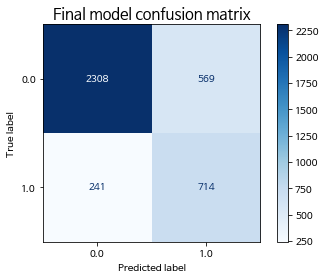

In [ ]:
# confusion matrix plot
plt.figure(figsize=(12, 8))
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, values_format = '.0f')
plt.title('Final model confusion matrix', size=15)
plt.show()

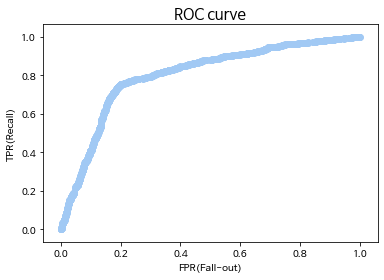

In [ ]:
# roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})

plt.scatter(fpr, tpr)
plt.title('ROC curve', size=15)
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');
plt.show()

In [ ]:
# X_train dataframe copy
X_train1 = X_train.copy()
X_test1 = X_test.copy()

n_pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent')
)
# 각 데이터 Ordinalencoder 및 Simpleimputer을 통한 데이터 셋 변환
X_train_tf = n_pipe.fit_transform(X_train1)
X_test_tf = n_pipe.transform(X_test1)

In [ ]:
X_train_tf = pd.DataFrame(X_train_tf, columns=X_train.columns)
X_test_tf = pd.DataFrame(X_test_tf, columns=X_train.columns)
# XGB 모델 학습
model = XGBClassifier(max_depth=6, 
                      learning_rate=0.01, 
                      n_estimators=238,
                      scale_pos_weight=3, 
                      subsample=0.8, 
                      random_state=20)
model.fit(X_train_tf, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=238, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=20,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3, seed=None,
              silent=None, subsample=0.8, verbosity=1)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


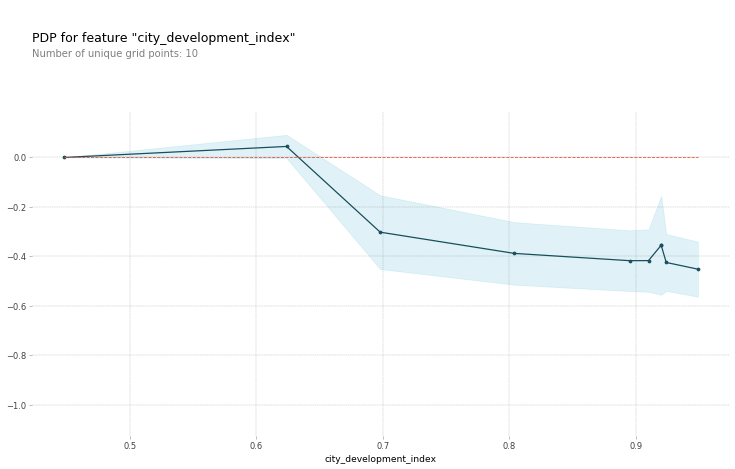

In [ ]:
plt.rcParams['figure.dpi'] = 60
feature = 'city_development_index'

# PDP plots
isolated = pdp_isolate(
    model=model, 
    dataset=X_train_tf, 
    model_features=X_train_tf.columns, 
    feature=feature
)


pdp_plot(isolated, feature_name=feature);
plt.show()

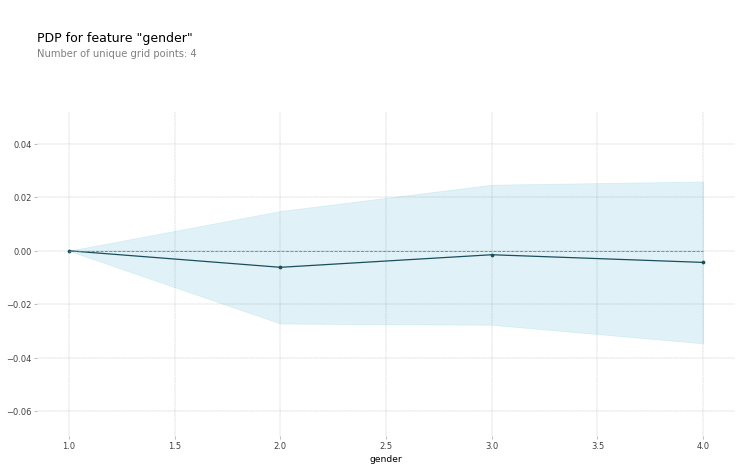

In [ ]:
feature = 'gender'

# PDP plots
isolated = pdp_isolate(
    model=model, 
    dataset=X_train_tf, 
    model_features=X_train_tf.columns, 
    feature=feature
)


pdp_plot(isolated, feature_name=feature);
plt.show()

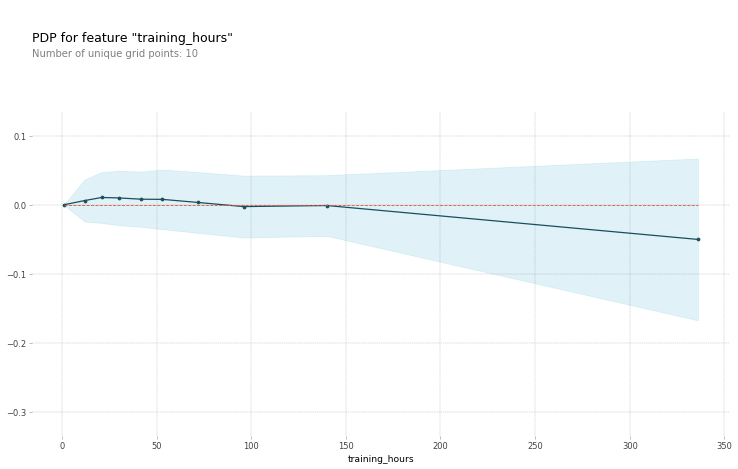

In [ ]:
feature = 'training_hours'

# PDP plots
isolated = pdp_isolate(
    model=model, 
    dataset=X_train_tf, 
    model_features=X_train_tf.columns, 
    feature=feature
)


pdp_plot(isolated, feature_name=feature);
plt.show()

In [ ]:
shap_bar = X_test_tf.iloc[[1]]
model.predict(shap_bar)

shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(shap_bar)

shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=shap_bar
)

In [ ]:
row = X_test_tf.iloc[:100]

shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)
shap.force_plot(explainer.expected_value, shap_values, row)

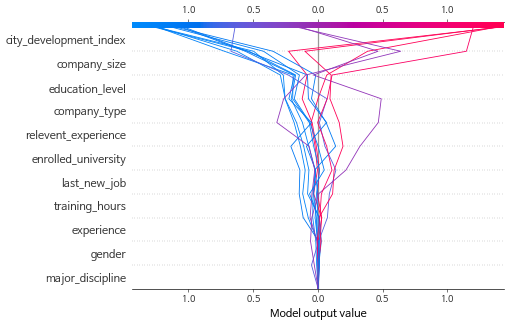

In [ ]:
row = X_test_tf.iloc[:15]

shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)
shap.decision_plot(explainer.expected_value, shap_values, row, feature_names=X_test_tf.columns.tolist())

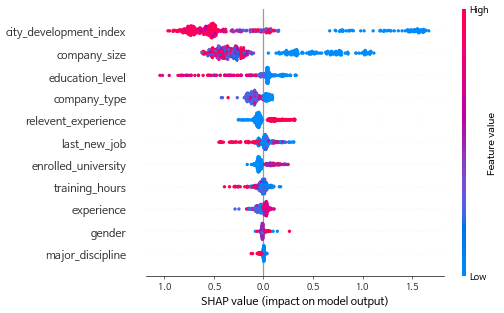

In [ ]:
row = X_test_tf.iloc[:400]

shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)
shap.summary_plot(shap_values, row)

In [ ]:
permuter = PermutationImportance(
    model,
    scoring='roc_auc', 
    n_iter=5,
    random_state=20
)

permuter.fit(X_train_tf, y_train)

PermutationImportance(cv='prefit',
                      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              learning_rate=0.01,
                                              max_delta_step=0, max_depth=6,
                                              min_child_weight=1, missing=None,
                                              n_estimators=238, n_jobs=1,
                                              nthread=None,
                                              objective='binary:logistic',
                                              random_state=20, reg_alpha=0,
                                              reg_lambda=1, scale_pos_weight=3,
                                              seed=None, silent=None,
                   

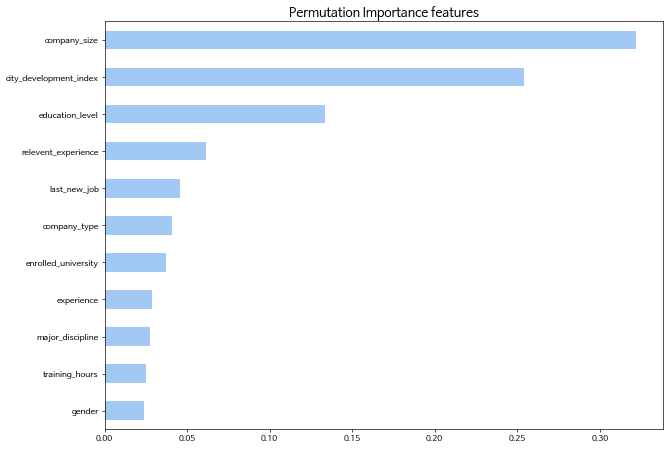

In [ ]:
# Permutation importance feature plot
importances = pd.Series(model.feature_importances_, X_train1.columns)
plt.figure(figsize=(12, 9))
plt.title(f'Permutation Importance features', size=15)
importances.sort_values().plot.barh();